In [1]:
import sunpy.map
import sunpy.visualization.colormaps as cm
import sunpy.sun.constants
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from aiapy.calibrate import register, update_pointing,normalize_exposure,correct_degradation
from aiapy.psf import deconvolve

import astropy.units as u
from astropy.constants import G, M_sun, R_sun, au
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy.units import imperial
from astropy.stats import gaussian_fwhm_to_sigma

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd
import math
from math import pi
import glob
import time
import datetime
import os
import importlib
import warnings

from PIL import Image
from fpdf import FPDF

import aia_part
from aia_part.pixel_to_world.std_pixel_to_world import std_pixel_to_world
from aia_part.pixel_to_world.my_pixel_to_world import my_pixel_to_world
from aia_part.calculate_DN import calculate_DN
from aia_part.gaussian_fit_aia import gaussian_fit_aia
from aia_part.data.constant import wavelength_list_aia_absolute

In [62]:
aia_files=sorted(glob.glob('aia_part/data/AIA/*.fits'))

In [63]:
aia_files

['aia_part/data/AIA\\aia_lev1_304a_2010_06_01t00_00_08_12z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_02t00_05_38_12z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_03t00_00_02_13z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_04t00_00_02_13z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_05t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_06t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_07t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_08t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_09t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_10t00_00_05_50z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_11t00_00_02_12z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_12t00_00_02_13z_image_lev1.fits',
 'aia_part/data/AIA\\aia_lev1_304a_2010_06_13t00_00_02_12z_image_lev1.fits',

In [89]:
smap=sunpy.map.Map(aia_files[1])
data=smap.data
data

array([[ -2,   0,   1, ...,  -3,   0,   1],
       [ -1,   0,  -2, ...,   1,   1,  -1],
       [  0,  -2,  -1, ...,  -1,   1, 253],
       ...,
       [ -1,   1,  -1, ...,  -2,  -1,   1],
       [ -1,   2,   0, ...,  -1,  -3,   0],
       [  0,   0,   0, ...,  -1,   0,  -1]], dtype=int16)

In [90]:
np.shape(data)

(4096, 4096)

In [91]:
data.itemsize

2

In [84]:
int16_size=data.nbytes
int16_size

33554432

In [88]:
int16_size/(1024**2)

32.0

In [101]:
smap=sunpy.map.Map(aia_adjusted_files[1])
data=smap.data
data

array([[0.00000000e+00, 2.90102323e-05, 0.00000000e+00, ...,
        2.22357984e-02, 0.00000000e+00, 1.61826336e-03],
       [2.98701905e-04, 0.00000000e+00, 3.69243225e-05, ...,
        0.00000000e+00, 1.61026390e-03, 0.00000000e+00],
       [0.00000000e+00, 3.96435074e-04, 0.00000000e+00, ...,
        2.27691126e-03, 0.00000000e+00, 1.65046568e-04],
       ...,
       [2.39415862e-05, 0.00000000e+00, 4.07650920e-04, ...,
        7.73361317e-05, 5.29361967e-05, 0.00000000e+00],
       [0.00000000e+00, 1.73836997e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.86985735e-05],
       [1.15580561e-04, 0.00000000e+00, 2.00553893e-03, ...,
        5.01864655e-06, 3.46958928e-06, 0.00000000e+00]], dtype='>f8')

In [95]:
data.itemsize

8

In [102]:
temp=data.astype(np.float32)

In [104]:
temp.nbytes/(1024**2)

64.0

In [97]:
float64_size=data.nbytes
float64_size/(1024**2)

128.0

In [ ]:
float64_size

In [ ]:
temp=data.astype(np.int)

In [75]:
data.max()

2031.205992607733

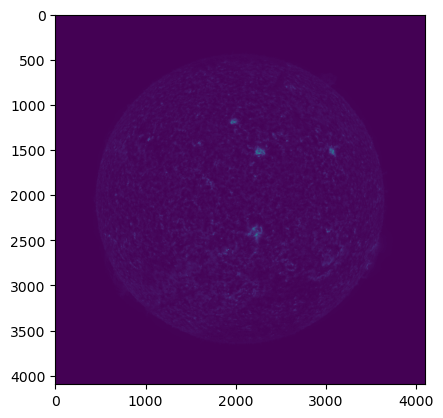

In [73]:
plt.imshow(data)

In [71]:
x=64
x*496**2*1.4e4/(1024**3)

205.291748046875

In [2]:
aia_adjusted_files=sorted(glob.glob('aia_part/data/AIA_1p5/*adjusted.fits'))
len(aia_adjusted_files)

1460

In [3]:
smap=sunpy.map.Map(aia_adjusted_files[0])

In [6]:
data=smap.data

In [51]:
np.float32

numpy.float32

In [3]:
data_list=[]
for i in range(1000):
    smap=sunpy.map.Map(aia_adjusted_files[i])
    data=(smap.data).astype(np.float32)
    data_list.append(data)

In [14]:
temp=np.array(data_list[0])

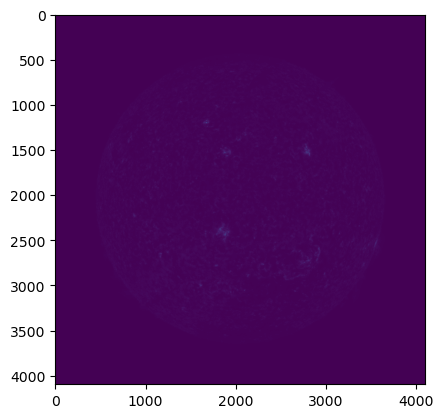

In [10]:
plt.imshow(temp[0])

In [5]:
np.save('data_list.npy', data_list[])

MemoryError: Unable to allocate 125. GiB for an array with shape (1000, 4096, 4096) and data type float64

In [ ]:
aia_adjusted_maps=[]


for i in range(len(aia_adjusted_files)):
    try:
        aia_adjusted_maps.append(sunpy.map.Map(aia_adjusted_files[i]))
    except:
        print(aia_adjusted_files[i])

In [22]:
temp.nbytes/(1024**2)

128.0

In [17]:
temp.itemsize

8

In [18]:
temp.dtype

dtype('>f8')

In [19]:
temp

array([[3.30081588e-03, 0.00000000e+00, 0.00000000e+00, ...,
        5.99228092e-06, 0.00000000e+00, 4.23066271e-07],
       [0.00000000e+00, 5.69151174e-02, 2.55237912e-01, ...,
        0.00000000e+00, 5.15415928e-06, 0.00000000e+00],
       [0.00000000e+00, 7.53415413e-02, 4.72392725e-01, ...,
        1.25361319e-04, 0.00000000e+00, 8.97128604e-06],
       ...,
       [0.00000000e+00, 2.95110010e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.23179935e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.37229329e-09, 0.00000000e+00, 8.69919050e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]], dtype='>f8')

In [24]:
a=np.array([1,2,3.])
a

array([1., 2., 3.])

In [25]:
a.itemsize

8

In [26]:
a.dtype

dtype('float64')

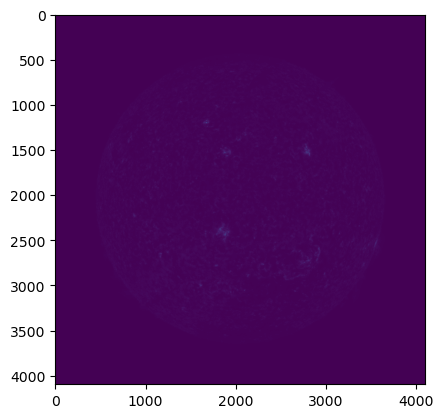

In [28]:
plt.imshow(temp)

In [29]:
temp.dtype

dtype('>f8')

In [34]:
temp=temp.astype(np.float64)

In [35]:
temp

dtype('float64')

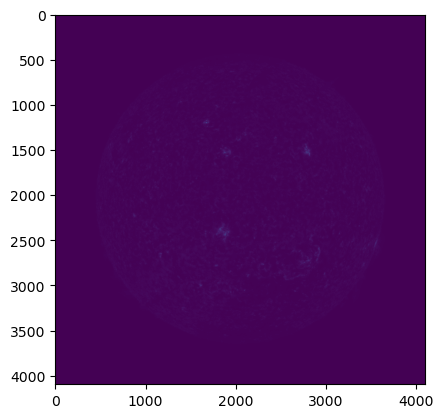

In [36]:
plt.imshow(temp)

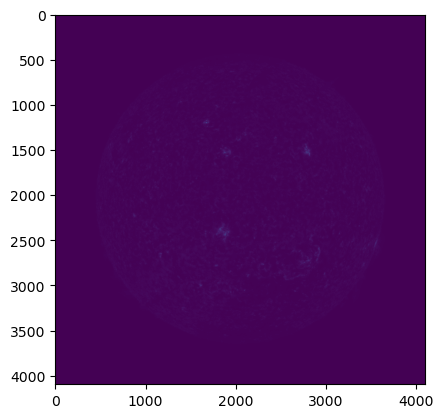

In [37]:
plt.imshow(temp.astype(np.float32))

In [39]:
plt.imshow(temp.astype(np.float8))

AttributeError: module 'numpy' has no attribute 'float8'

In [41]:
temp.dtype

dtype('float64')

In [42]:
np.sum(temp)

449542900.5037022

In [58]:
np.sum(temp.astype(np.float32))

449542820.0

In [59]:
np.sum(temp.astype(np.float16))

C:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

overflow encountered in reduce



inf

In [46]:
temp.astype(np.float32).nbytes

67108864

In [47]:
temp.nbytes

134217728

In [50]:
np.nanmax(temp)

4885.217588447478

In [1]:
import numpy as np
from scipy.ndimage import zoom

# Sample 4x4 array
original_array = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

# Define the desired size of the new array (8x8)
new_shape = (8, 8)

# Calculate the zoom factors for each dimension
zoom_factors = (np.array(new_shape) / np.array(original_array.shape)).tolist()

# Resample the array to the new shape using bilinear interpolation
resampled_array = zoom(original_array, zoom_factors, order=1)

print("Original Array:")
print(original_array)

print("\nResampled Array:")
print(resampled_array)


Original Array:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Resampled Array:
[[ 1  1  2  2  3  3  4  4]
 [ 3  3  4  4  4  5  5  6]
 [ 4  5  5  6  6  7  7  7]
 [ 6  7  7  7  8  8  9  9]
 [ 8  8  9  9 10 10 10 11]
 [10 10 10 11 11 12 12 13]
 [11 12 12 13 13 13 14 14]
 [13 13 14 14 15 15 16 16]]


In [35]:
import numpy as np
import sunpy.image.resample as resample

# Create an original numpy array (5x5) with some values for demonstration
original_array = np.array([[1, 2, 3, 4],
                           [6, 7, 8, 9],
                           [11, 12, 13, 14],
                           [16, 17, 18, 19]])

# Define the dimensions you want the new array to have (e.g., (3, 3))
desired_dimensions = [8, 8]
# desired_dimensions = [2, 2]

# Resample the original array to the desired dimensions using linear interpolation
new_array = resample.resample(original_array, desired_dimensions, method='linear',
                              # center=True,
                              # minusone=True,
                             )

# Print the original and resampled arrays
print("Original Array:")
print(original_array)
print("\nResampled Array:")
print(new_array)


Original Array:
[[ 1  2  3  4]
 [ 6  7  8  9]
 [11 12 13 14]
 [16 17 18 19]]

Resampled Array:
[[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5]
 [ 3.5  4.   4.5  5.   5.5  6.   6.5  7. ]
 [ 6.   6.5  7.   7.5  8.   8.5  9.   9.5]
 [ 8.5  9.   9.5 10.  10.5 11.  11.5 12. ]
 [11.  11.5 12.  12.5 13.  13.5 14.  14.5]
 [13.5 14.  14.5 15.  15.5 16.  16.5 17. ]
 [16.  16.5 17.  17.5 18.  18.5 19.  19.5]
 [18.5 19.  19.5 20.  20.5 21.  21.5 22. ]]


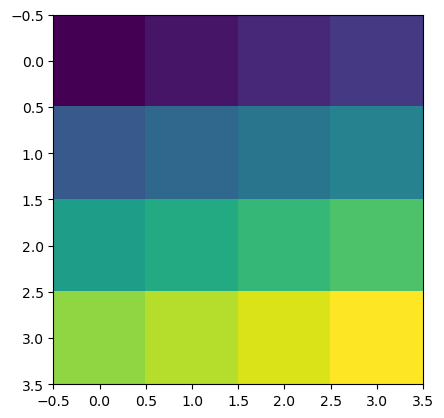

In [24]:
plt.imshow(original_array)

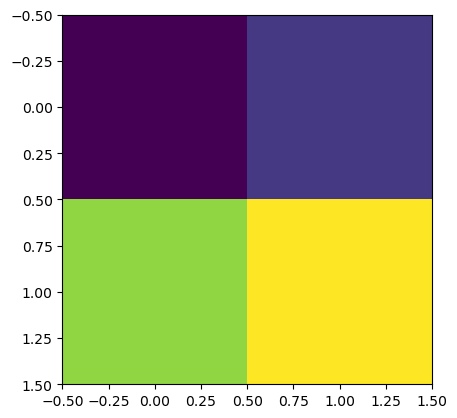

In [25]:
plt.imshow(new_array)

In [15]:
import matplotlib.pyplot as plt

In [38]:
import timeit

# Using list comprehension
def list_comprehension():
    return [num ** 2 for num in range(1, 10000)]

# Using traditional for loop
def for_loop():
    squared_numbers = []
    for num in range(1, 10000):
        squared_numbers.append(num ** 2)
    return squared_numbers

# Measure the execution time for both approaches
time_list_comprehension = timeit.timeit(list_comprehension, number=1000)
time_for_loop = timeit.timeit(for_loop, number=1000)

print("List Comprehension Time:", time_list_comprehension)
print("For Loop Time:", time_for_loop)

List Comprehension Time: 2.1388052000002062
For Loop Time: 2.5207176999992953


In [46]:
import pandas as pd
import datetime

# Sample DataFrame with datetime column
data = {
    'Time': [datetime.datetime(2023, 7, 21, 12, 0, 0),
             datetime.datetime(2023, 7, 21, 13, 0, 0)]
}

df = pd.DataFrame(data)

# Pandas automatically infers the data type of 'Time' column as 'datetime64[ns]'
print(df.dtypes)

# Accessing a value from the datetime column gives a Pandas Timestamp object
print(df['Time'][0])


Time    datetime64[ns]
dtype: object
2023-07-21 12:00:00
